In [1]:
from monai.transforms import (
    Compose,
    KeepLargestConnectedComponent,
    AsDiscrete,
    ResizeWithPadOrCrop,
    EnsureType,
    ScaleIntensity,
)
from skimage.filters import threshold_otsu,threshold_multiotsu

In [2]:
#load all GTVs
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
from lungmask import mask as lungmask_fun
from skimage.measure import label, regionprops,shannon_entropy
from skimage.morphology import dilation,ball,erosion,remove_small_objects

from monai.utils import first, set_determinism
from monai.transforms import (
    SaveImage,
    ResizeWithPadOrCropd,
    MaskIntensityd,
    ScaleIntensityd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    ResizeWithPadOrCrop,
    LoadImaged,
    Orientationd,
    FillHoles,
    RemoveSmallObjects,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    RandSpatialCropd,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    Invertd,
    DivisiblePadd,
    MapTransform,
    RandWeightedCropd,
    ToTensord,
    Transpose,
    ScaleIntensity,
)
from monai.networks.nets import UNet,VNet,SwinUNETR,UNETR,DynUNet
from monai.metrics import DiceMetric,SurfaceDiceMetric,HausdorffDistanceMetric,compute_surface_dice
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate
from metrics import metrics_fun,saveMetrics_fun

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

if True:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print('plot in line')

device: cuda
plot in line


In [4]:
# class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        print(f"keys to transpose: {self.keys}")

    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0, 2, 3, 1))
                data = rotate(data, 270, axes=(1, 2), reshape=False)
                data = np.flip(data, 1)
                data[data == 2] = int(1)
                data[data != 1] = int(0)
            dictionary[key] = data

        return dictionary


In [5]:
root_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_AllBP_V2/'

In [6]:
def CreateLungMasks(root_path, CT_fpaths):
    # Get Lung mask and save it
    CT_path0 = CT_fpaths[0]
    CT_nii = nib.load(CT_path0)
    for ct in CT_fpaths:
        empty_header = nib.Nifti1Header()
        lung_path = ct[:-10] + '_LungMask.nii.gz'
        print('Creating Lung Mask: ', lung_path)
        input_image = sitk.ReadImage(ct, imageIO='NiftiImageIO')
        lungmask = lungmask_fun.apply(input_image)  # default model is U-net(R231)
        lungmask_ni = nib.Nifti1Image(lungmask, CT_nii.affine, empty_header)
        nib.save(lungmask_ni, lung_path)
    return 0

In [7]:
def LookSortFiles_ITV_Eval(root_path, all_patientdir):
    CTALL_fpaths =[]
    lungALL_fpaths =[]
    itv_fpaths = []  
    predicted_fpaths =[]
    itv_miss = 0
    ct_miss =0
    lung_miss=0
    pred_miss=0
    #Look for labels
    for patient_path in all_patientdir:
        for root, dirs, files in os.walk(root_path + patient_path, topdown=False):
            for f in files:
                if '_igtv' in f.lower() and "predicted" not in f.lower():
                    itv_miss+=1
                    itv_fpaths.append(os.path.join(root_path, patient_path, f))
                elif '_itv' in f.lower() and "predicted" not in f.lower():
                    itv_miss+=1
                    itv_fpaths.append(os.path.join(root_path, patient_path, f))
                if '_ct' in f.lower() and "predicted" not in f.lower() and "ave" not in f.lower():
                    ct_miss+=1
                    CTALL_fpaths.append(os.path.join(root_path, patient_path, f))
                if 'lung' in f.lower() and "ave" not in f.lower():
                    lung_miss += 1
                    lungALL_fpaths.append(os.path.join(root_path, patient_path, f))
                if 'predicted12' in f.lower():
                    pred_miss+=1
                    predicted_fpaths.append(os.path.join(root_path, patient_path, f))
    
    for i in range(len(predicted_fpaths)-len(itv_fpaths)):
        itv_fpaths.append(itv_fpaths[0])
    
    CTALL_fpaths = np.sort(CTALL_fpaths)
    lungALL_fpaths = np.sort(lungALL_fpaths)
    itv_fpaths = np.sort(itv_fpaths)
    predicted_fpaths = np.sort(predicted_fpaths)
    print("CT image",ct_miss,"Lung",lung_miss,"ITV",itv_miss,"Pred",pred_miss)
    return CTALL_fpaths,itv_fpaths,lungALL_fpaths,predicted_fpaths

In [8]:
##MAIN
px_ = '0070683/'
all_patientdir = []
all_patientdir.append(px_)
#all_patientdir = os.listdir(root_path)
all_patientdir.sort()
CTALL_fpaths,itv_fpaths, lungALL_fpaths,predicted_fpaths = LookSortFiles_ITV_Eval(root_path, all_patientdir)
    
#Create data dictionat
data_dicts = [
    {"image": image_name,"ITV":itv_name,"lung":lung_name,"Pred":pred_name}
    for image_name,itv_name,lung_name,pred_name in zip(CTALL_fpaths,itv_fpaths,lungALL_fpaths,predicted_fpaths)
]
val_files =data_dicts[:]
print('CT val len:',len(val_files))


CT image 10 Lung 10 ITV 1 Pred 9
CT val len: 9


In [9]:
# HU are -1000 air , 0 water , usually normal tissue are around 0, top values should be around 100, bones are around 1000
minmin_CT = -1024
maxmax_CT = 200 
#Create Compose functions for preprocessing of train and validation
image_keys = ["image","lung","ITV","Pred"]
print("image_keys",image_keys)
size = 96
image_size = (size,size,size)
multiplier = 1
val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=["image","lung","ITV","Pred"]),
        Orientationd(keys=["image","ITV","Pred"], axcodes="RAS"),
        #Spacingd(keys=["image","label","GTV","Pred"], pixdim=(1,1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=["image","lung","ITV"]),
        CropForegroundd(keys=["image","ITV","lung"], source_key="lung",k_divisible=size),
        ResizeWithPadOrCropd(keys=["image","lung","ITV","Pred"],spatial_size=(384, 384, 192), method="symmetric"),
        #MaskIntensityd(keys=["image"], mask_key="lung"),
        #CropForegroundd(keys=image_keys, source_key="lung",k_divisible=size*multiplier),
        #AsDiscreted(keys=["Pred",],to_onehot=None,threshold=.01),
        ToTensord(keys=["image","lung","ITV"]),
    ]
)


image_keys ['image', 'lung', 'ITV', 'Pred']
keys to transpose: ('image', 'lung', 'ITV')


In [10]:
#Check the images after the preprocessing
check_ds =Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)    
batch_data = first(check_loader)
px = batch_data["image"].to('cpu').meta["filename_or_obj"][0].split('/')[-2]
image,lung,itv_label = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["ITV"][0][0])

In [11]:
Pred_list = []
for batch_data in check_loader:
    Pred_list.append(batch_data["Pred"][0][0])


In [12]:
# make 3 ITVs
def post(tensor):
    converted = tensor.cpu().detach().numpy()
    dilated = dilation(converted, ball(3))
    return torch.from_numpy(dilated)

def CreateITV(predicted_ITV, tresh, dilation_bool):
    # Creating ITV
    for k in range(len(predicted_ITV)):
        if k == 0:
            ITV_tensor_10BP = predicted_ITV[k]
            ITV_tensor_2BP = predicted_ITV[k]
        elif k == 5:
            ITV_tensor_2BP = torch.add(ITV_tensor_2BP, predicted_ITV[k])
            ITV_tensor_10BP = torch.add(ITV_tensor_10BP, predicted_ITV[k])
        elif k != 0 and k != 5:
            ITV_tensor_10BP = torch.add(ITV_tensor_10BP, predicted_ITV[k])

    # Creating Optimized ITV with otsu thresholding
    maxITV = ITV_tensor_10BP.max()
    otsu_val = threshold_otsu(ITV_tensor_10BP.detach().cpu().numpy())
    otsu_multival = threshold_multiotsu(ITV_tensor_10BP.detach().cpu().numpy(), classes=3)
    print(maxITV.item(), "Otsu: ", otsu_val, "Multival 1: ", otsu_multival[0], " 2: ", otsu_multival[-1])
    if False:
        to_hist = ITV_tensor_10BP.flatten().detach().cpu().numpy()
        plt.hist(to_hist, bins=256, range=(to_hist.min() + .1, to_hist.max()))
        plt.show()
    ITV_tensor_optimized = ITV_tensor_10BP.clone()
    if tresh == "Otsu":
        ITV_tensor_optimized[ITV_tensor_optimized < otsu_val] = 0
        ITV_tensor_optimized[ITV_tensor_optimized >= otsu_val] = 1
    else:
        ITV_tensor_optimized[ITV_tensor_optimized < otsu_multival[-1]] = 0
        ITV_tensor_optimized[ITV_tensor_optimized >= otsu_multival[-1]] = 1

    # Binarizing 2BP and 10BP
    ITV_tensor_10BP[ITV_tensor_10BP > 0] = 1
    ITV_tensor_2BP[ITV_tensor_2BP > 0] = 1
    if dilation_bool:
        ITV_10BP_dil = post(ITV_tensor_10BP)
        ITV_2BP_dil = post(ITV_tensor_2BP)
        ITV_Opti_dil = post(ITV_tensor_optimized)
        return ITV_tensor_10BP, ITV_tensor_2BP, ITV_tensor_optimized, ITV_10BP_dil, ITV_2BP_dil, ITV_Opti_dil
    else:
        return ITV_tensor_10BP, ITV_tensor_2BP, ITV_tensor_optimized

In [19]:

ITV_10BP,ITV_2BP,ITV_Opti,ITV_10BP_dil,ITV_2BP_dil,ITV_Opti_dil = CreateITV(Pred_list,"Otsu",True) #"Otsu" or "OtsuMulti" 



5.0 Otsu:  0.009765625 Multival 1:  0.029296875  2:  2.0019531


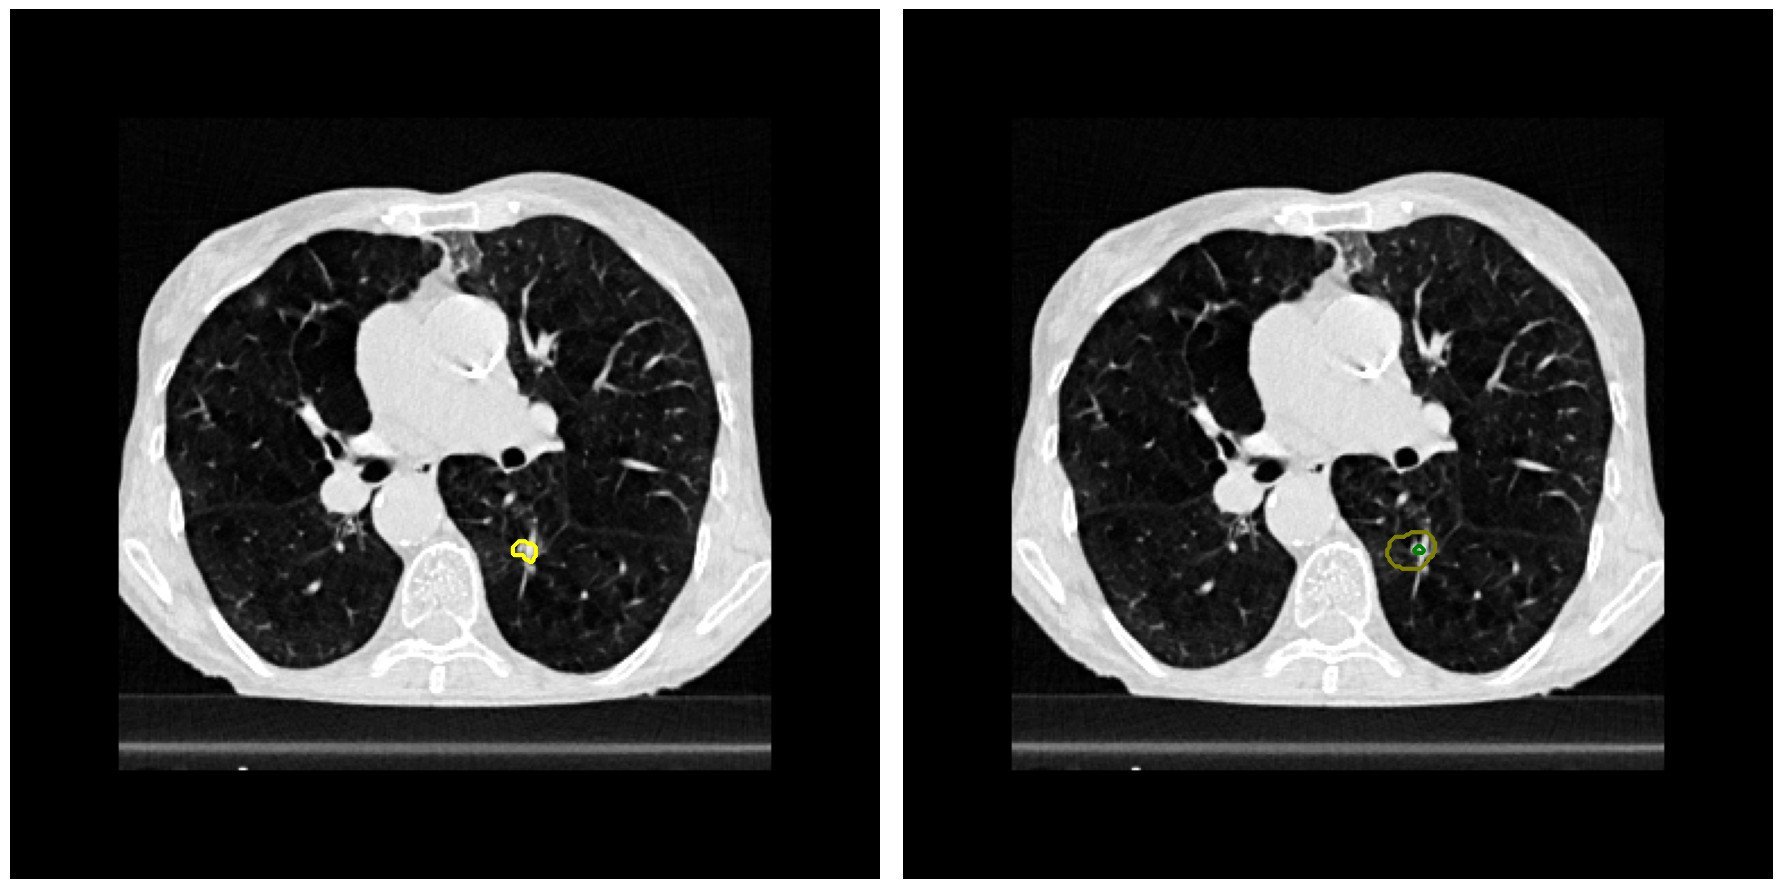

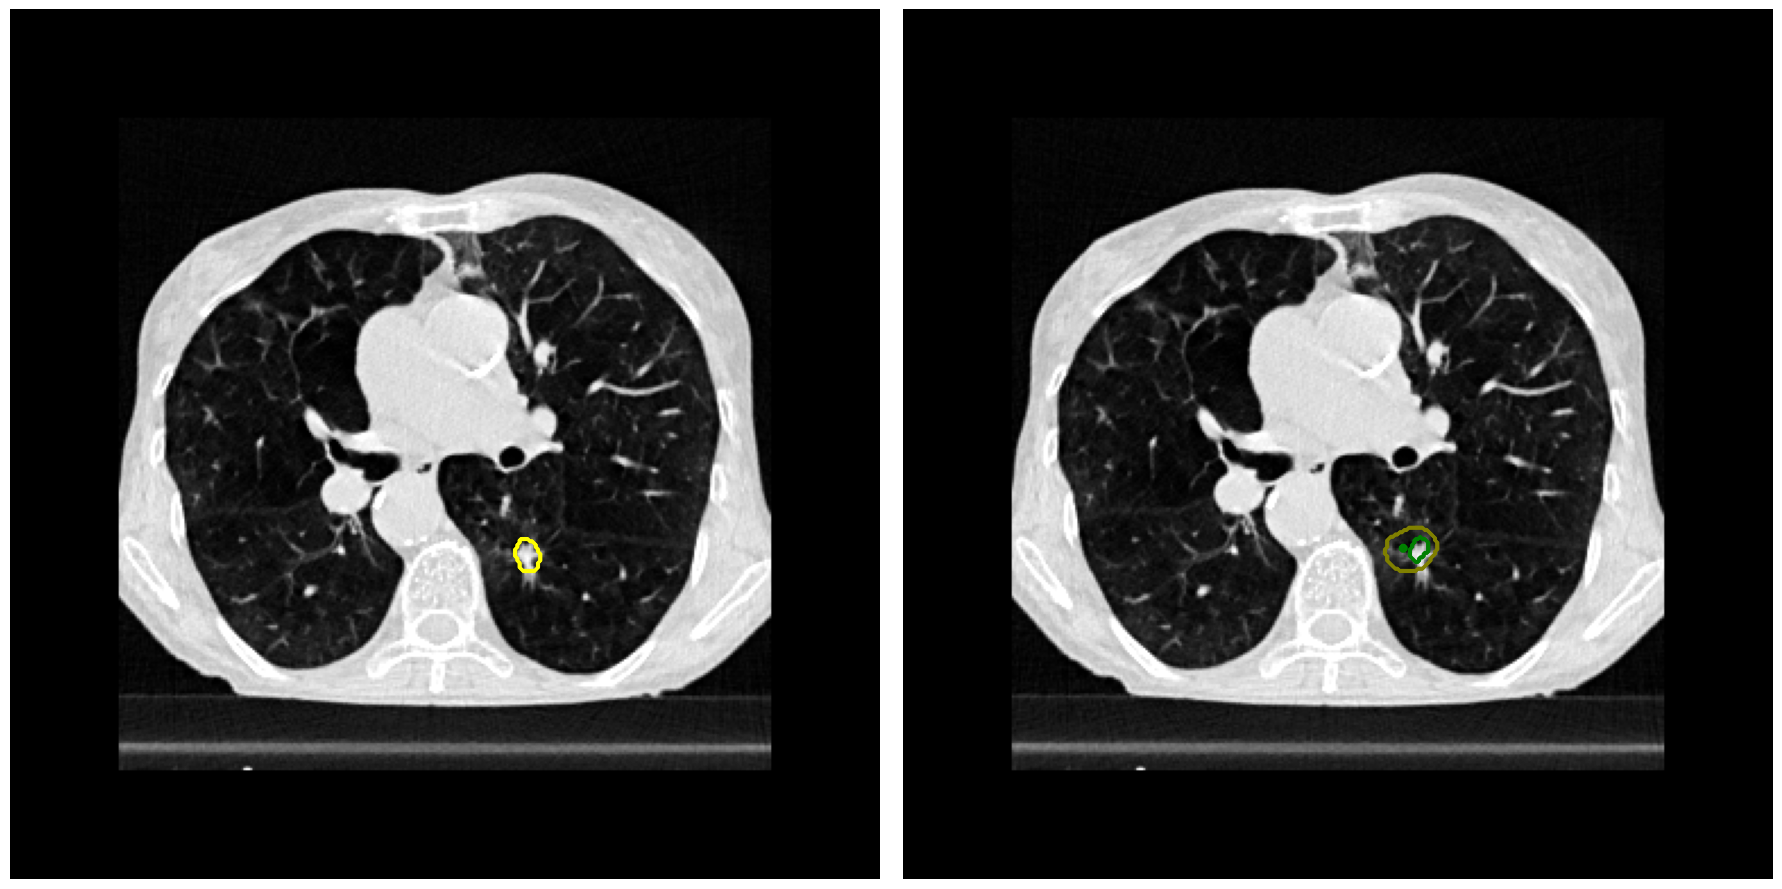

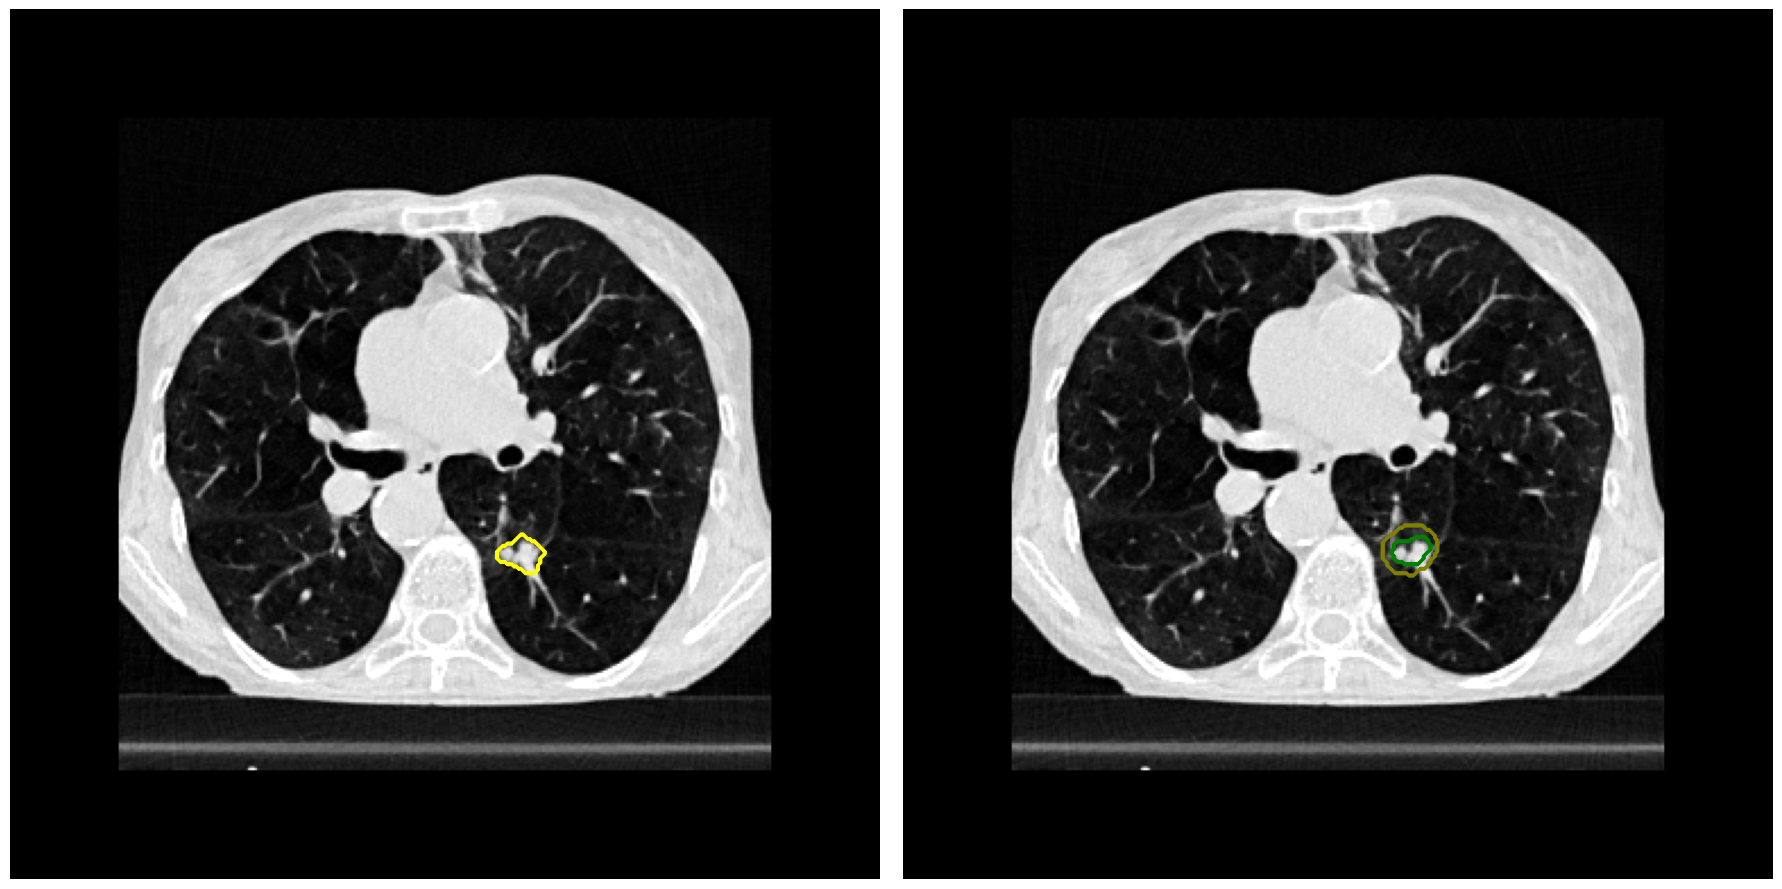

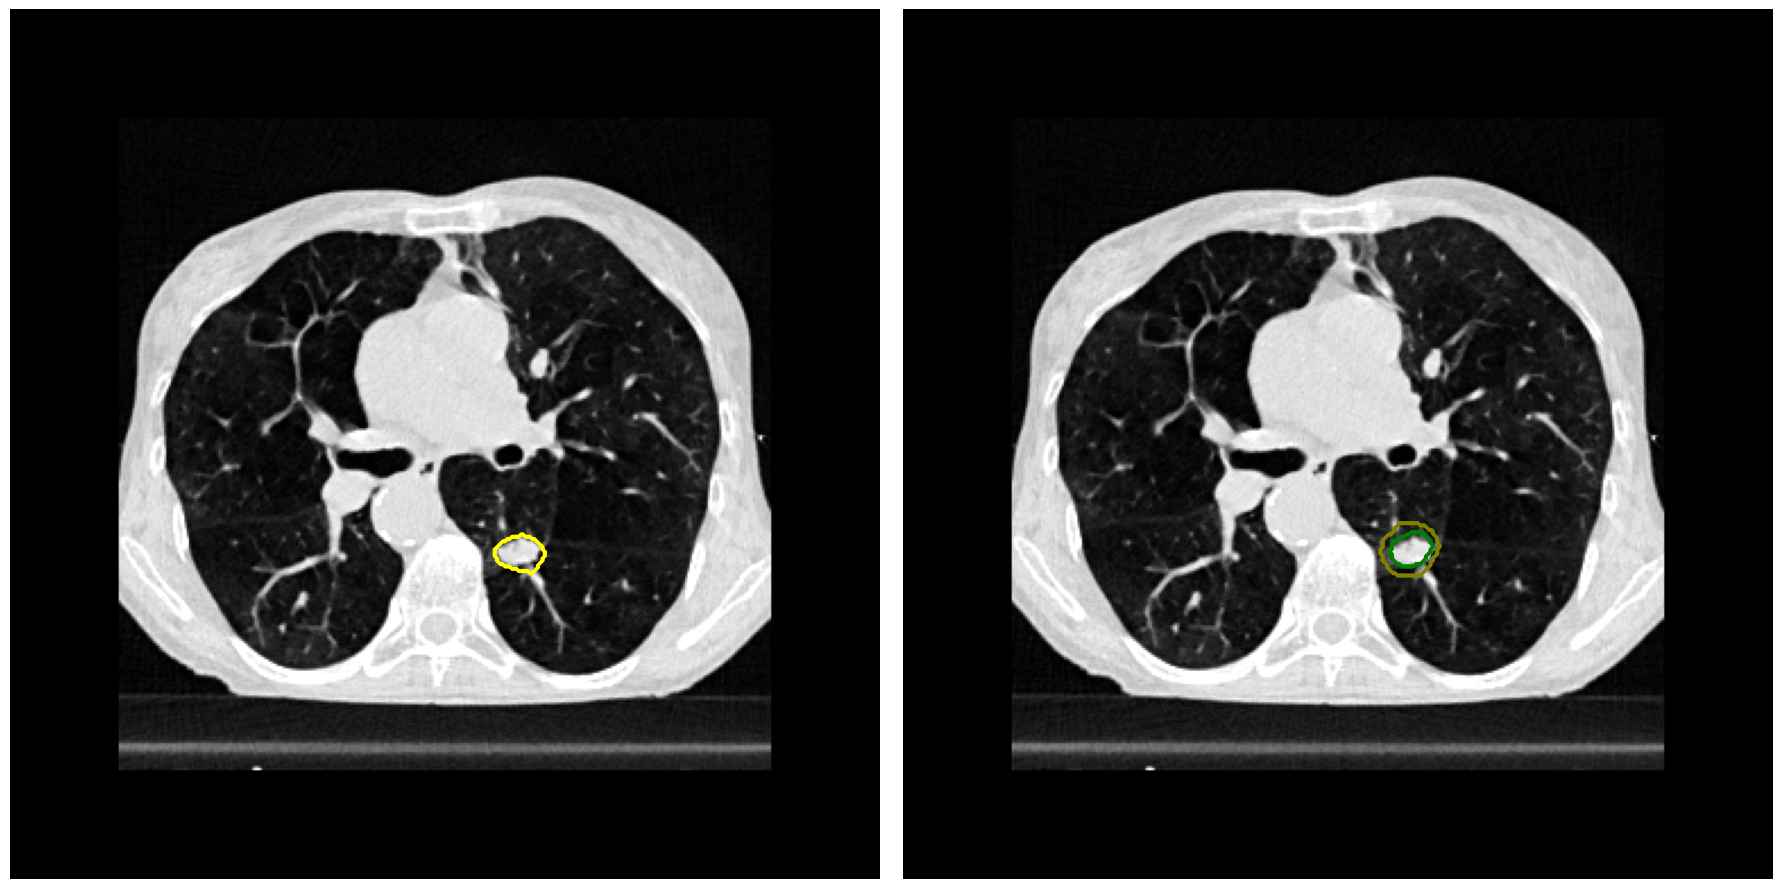

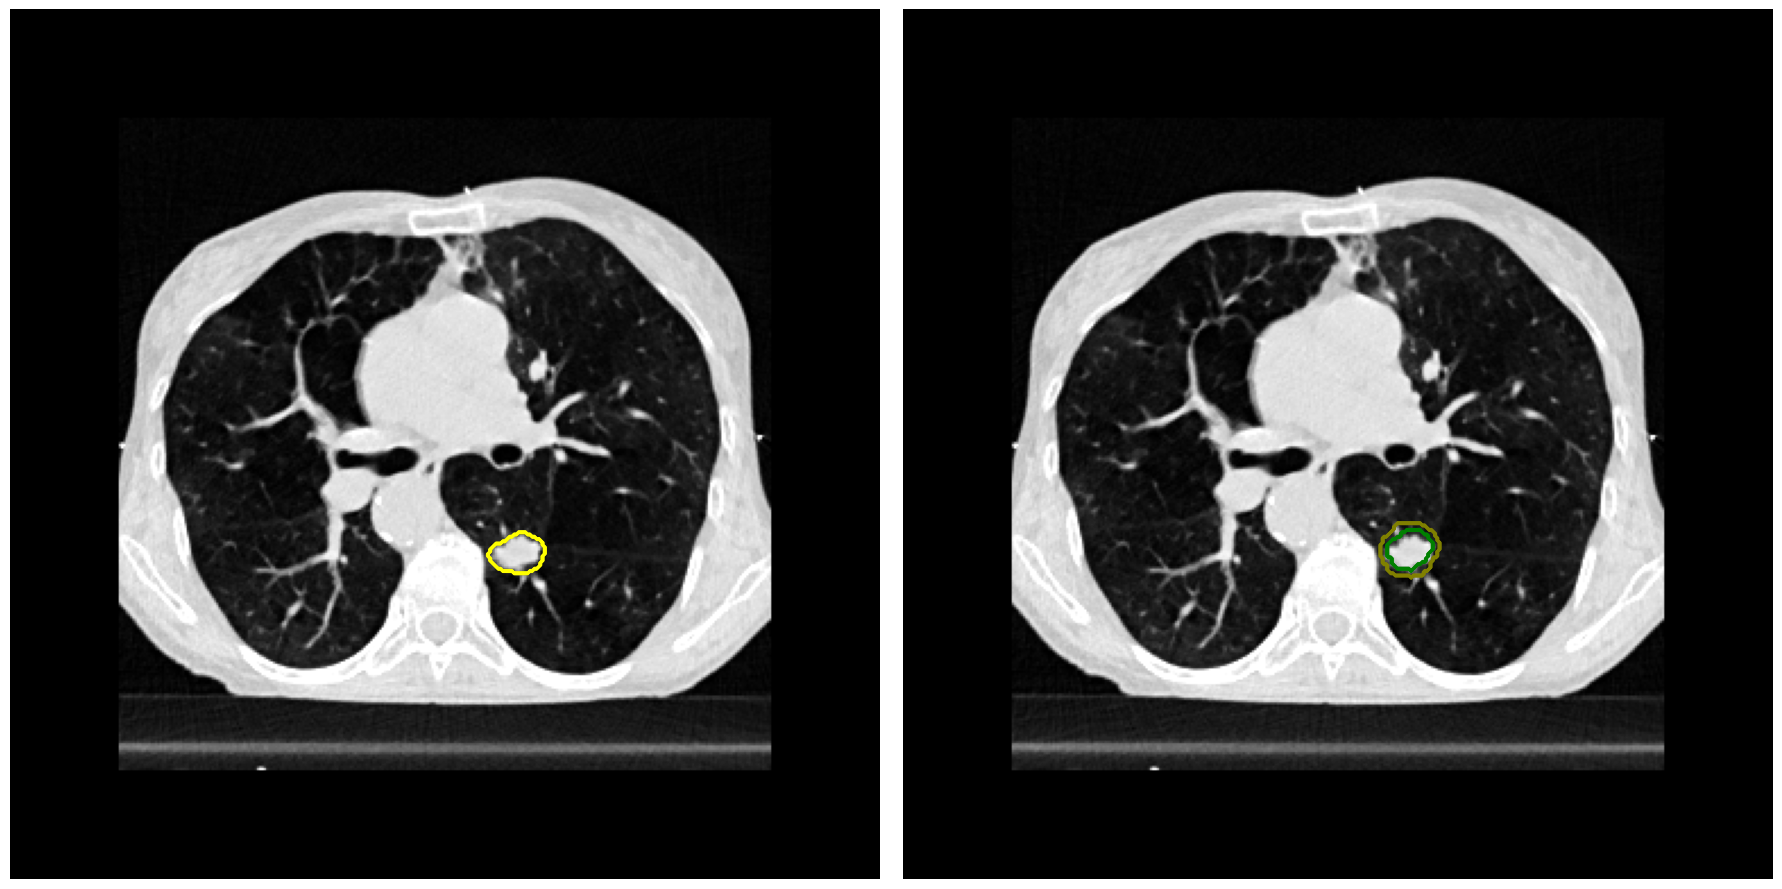

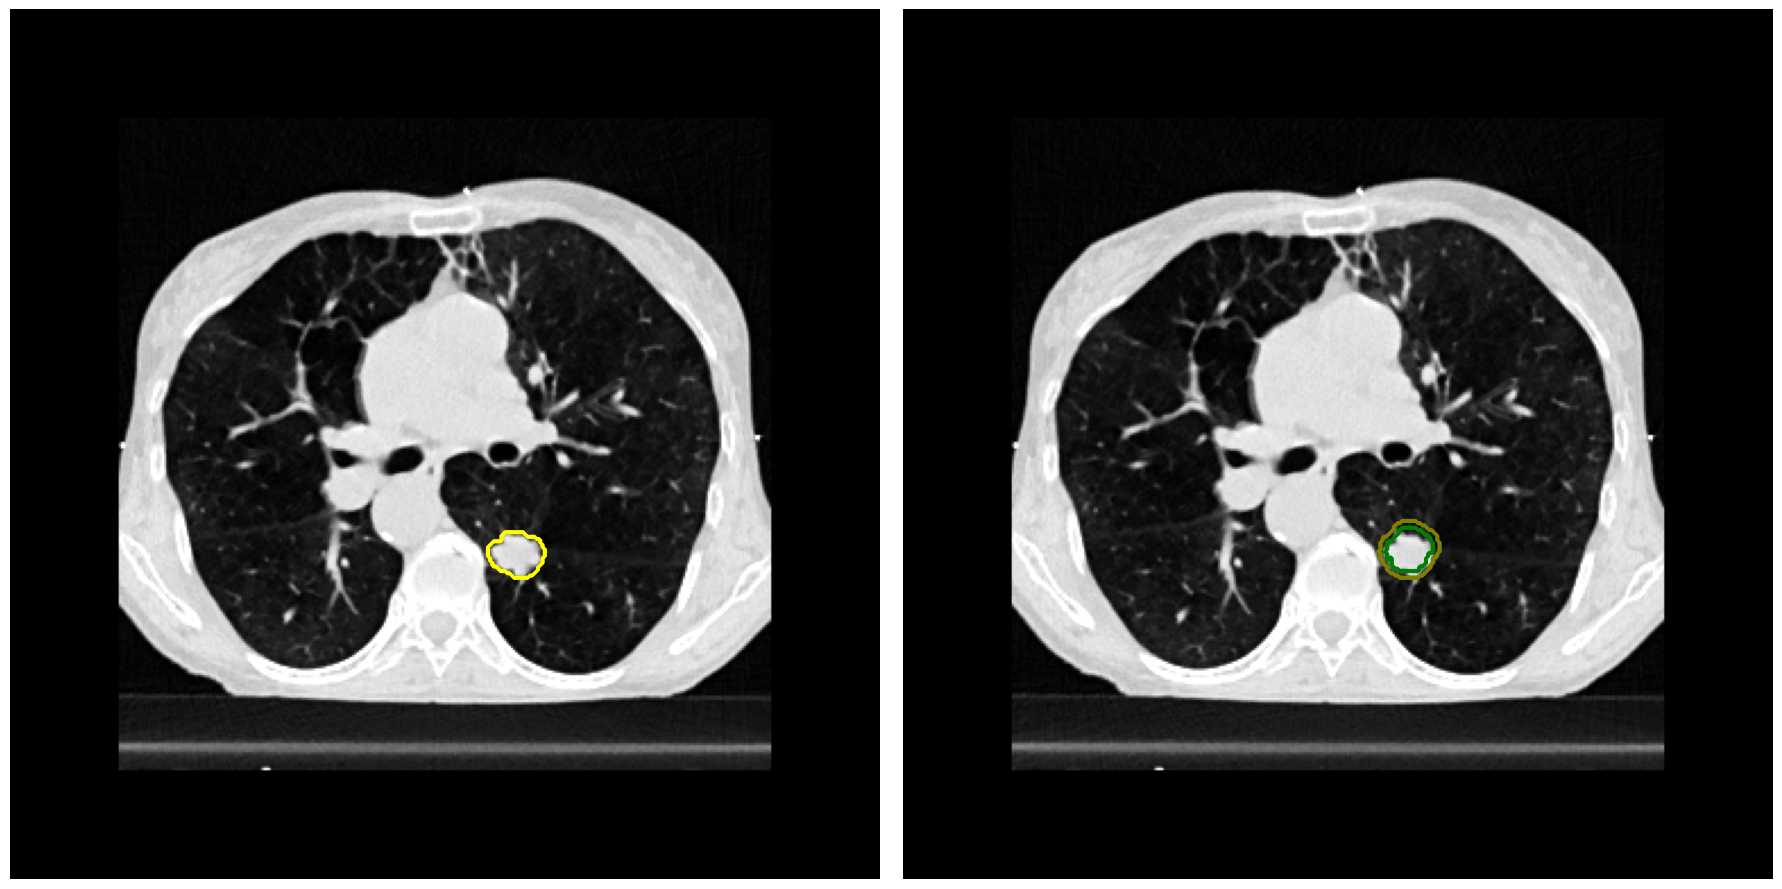

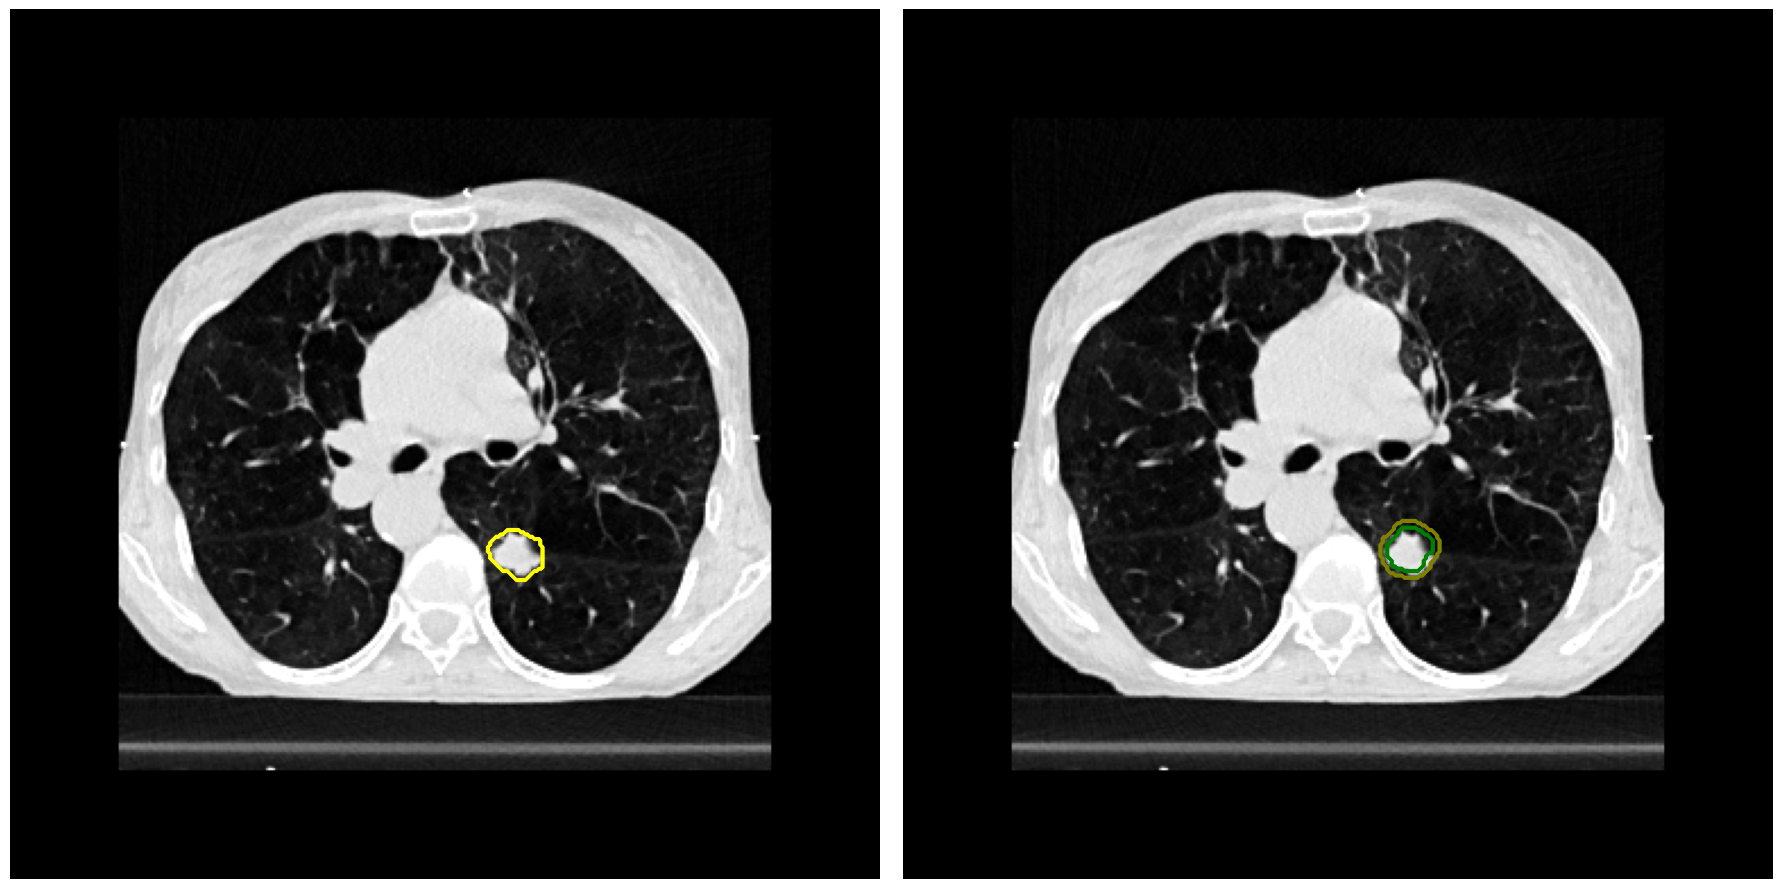

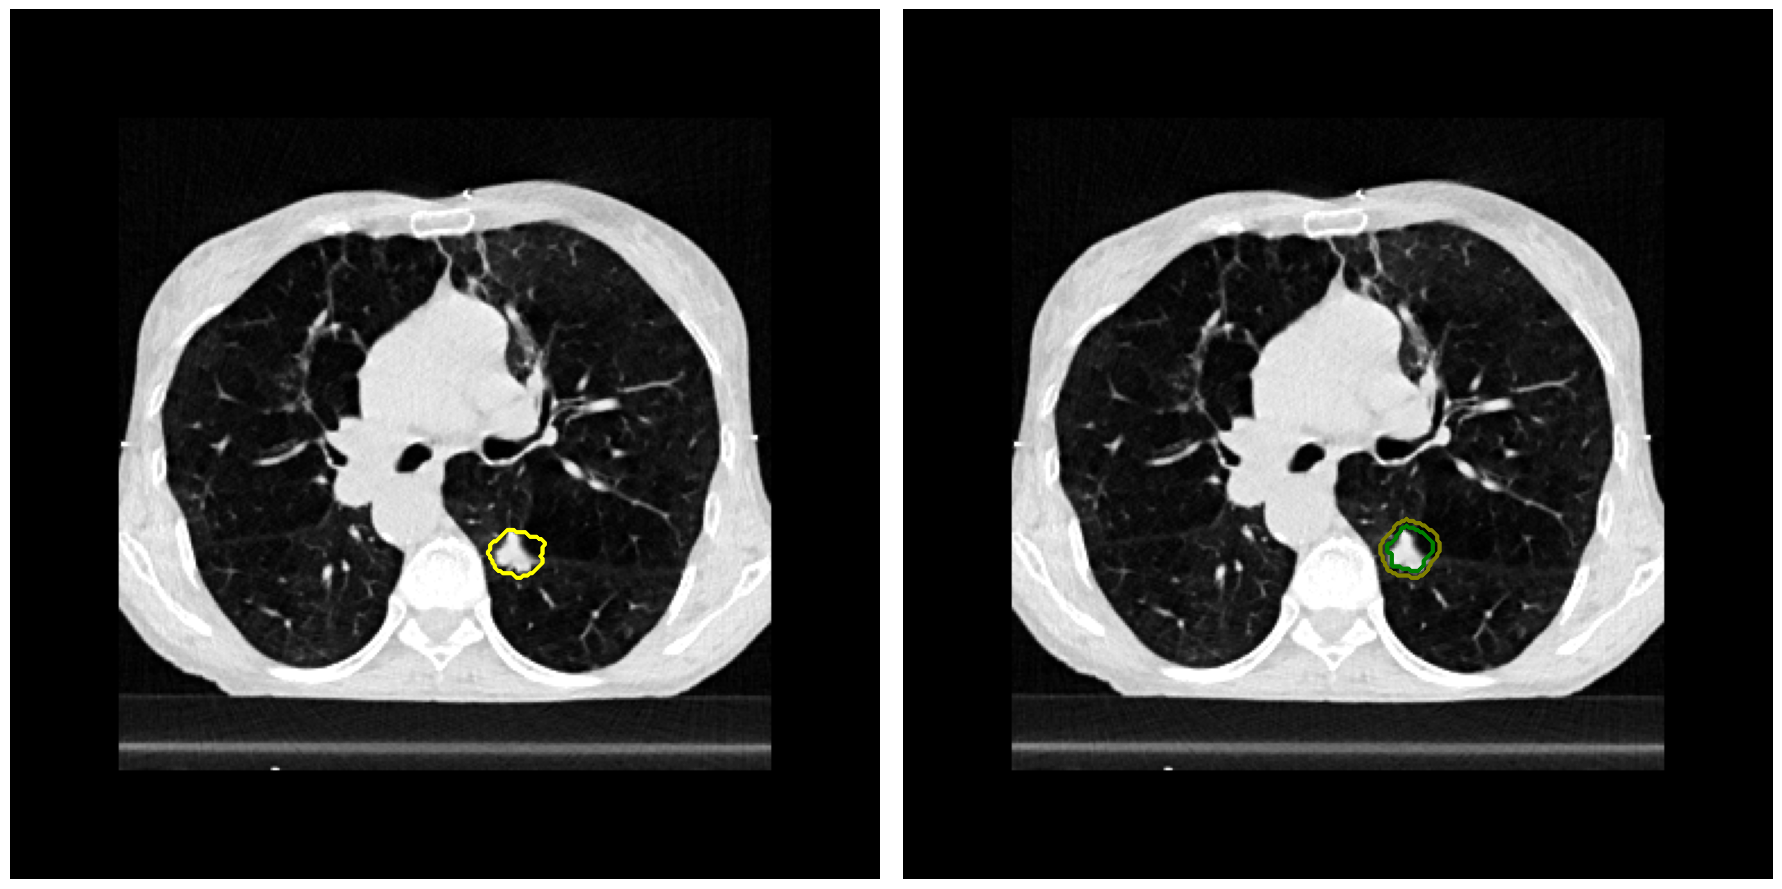

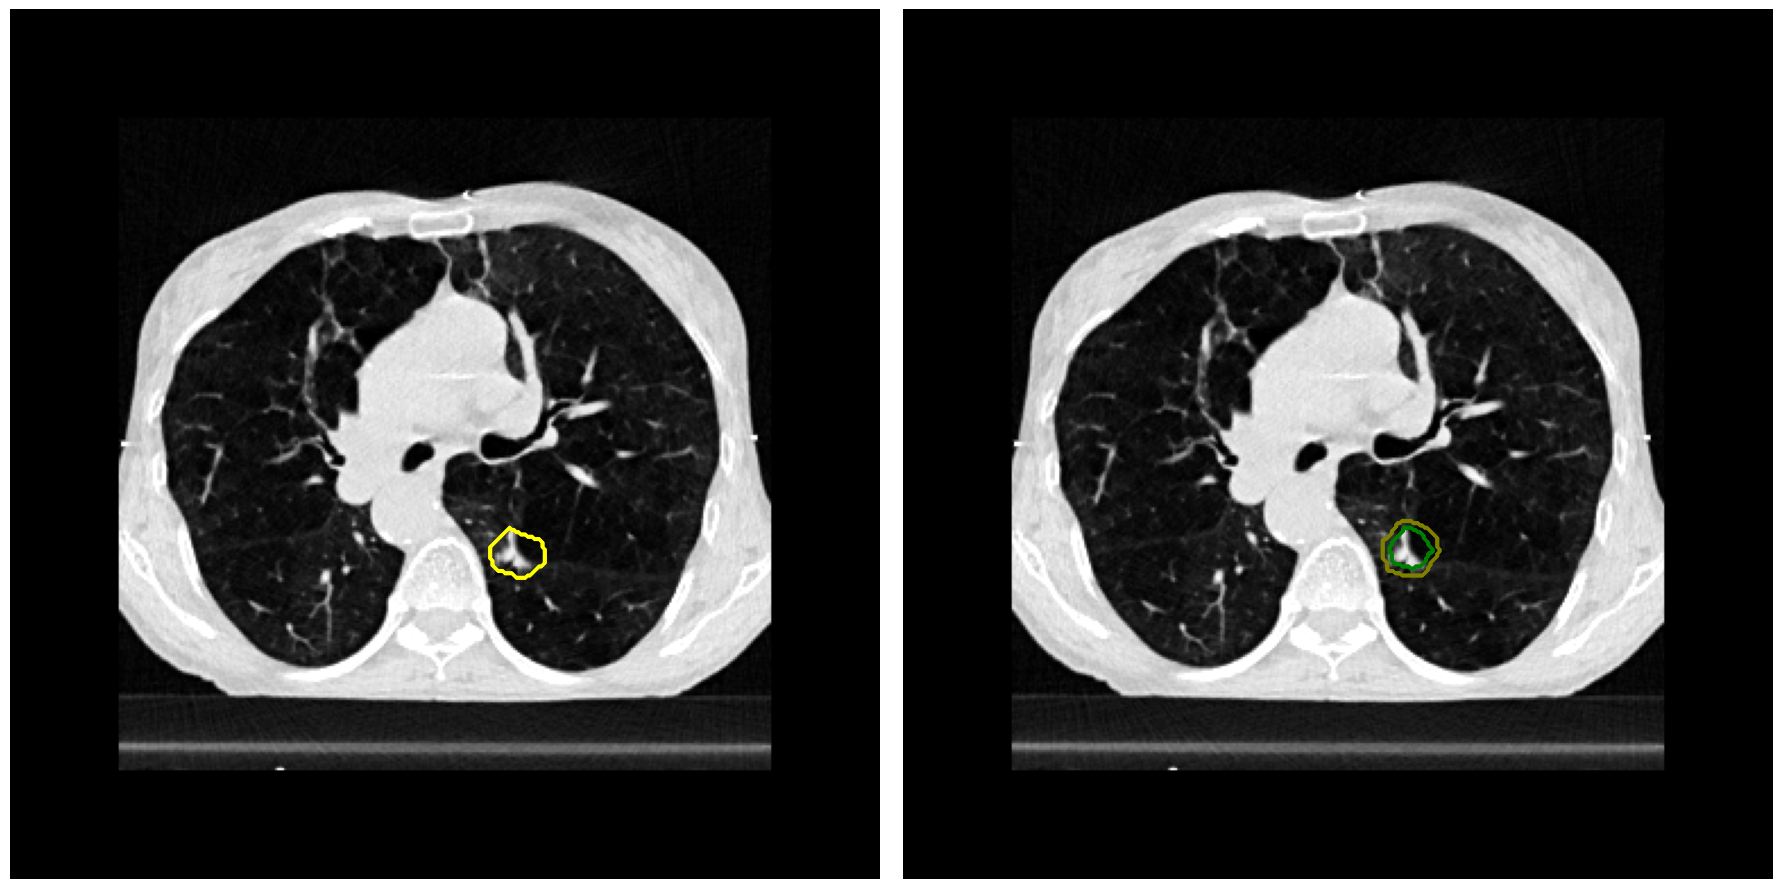

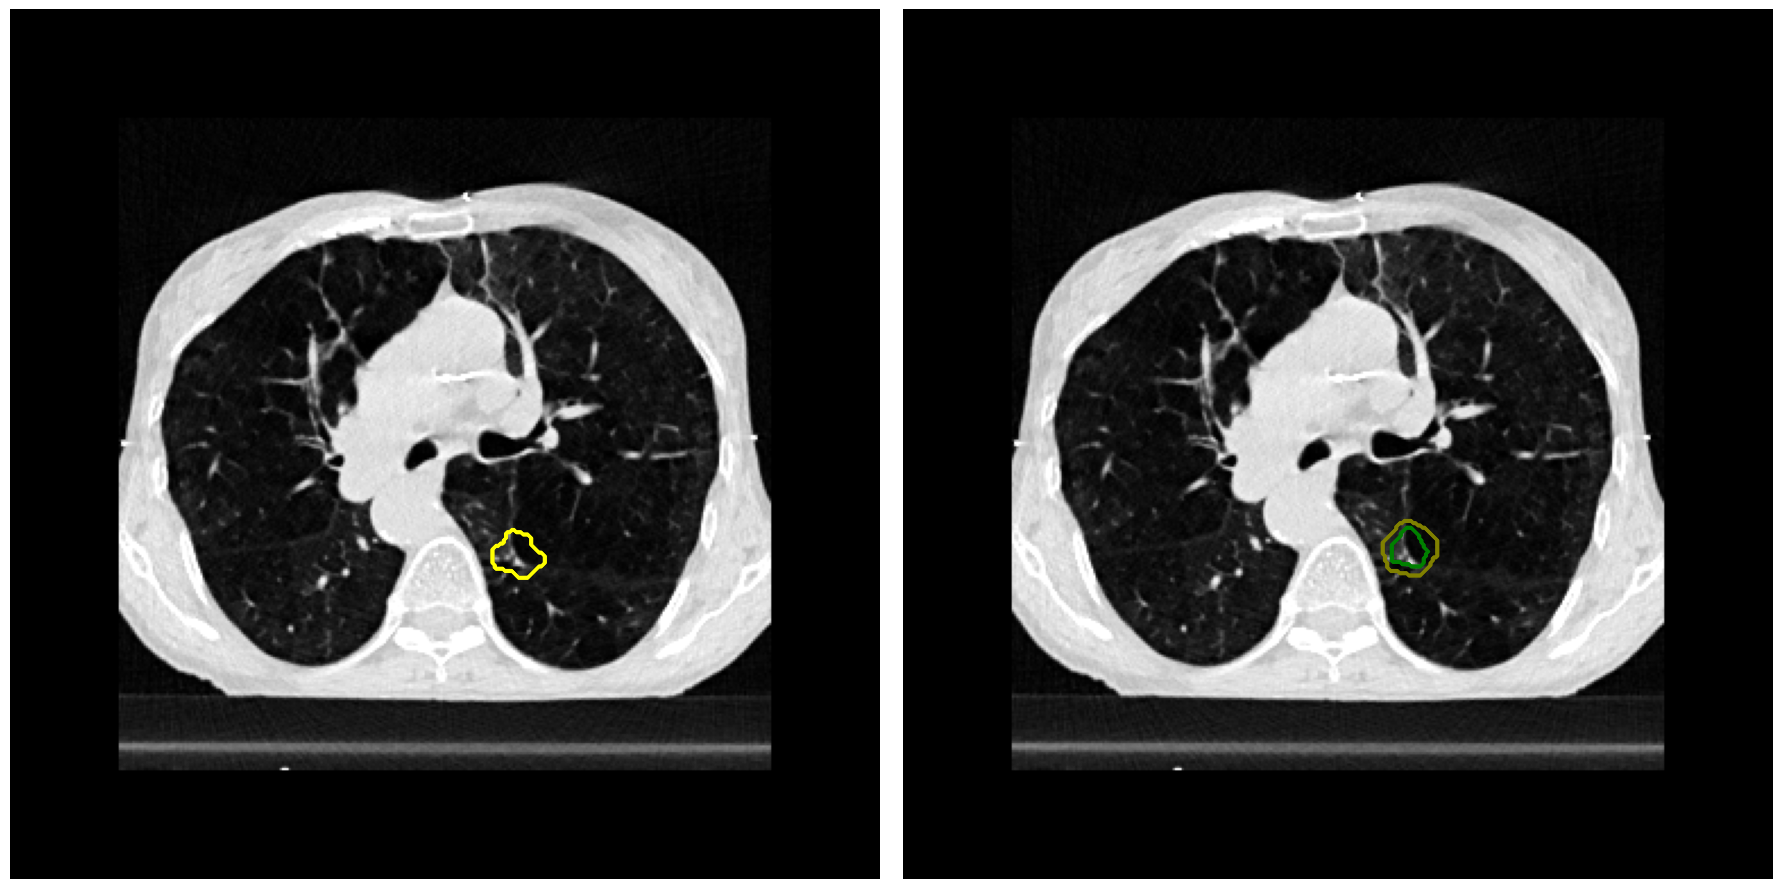

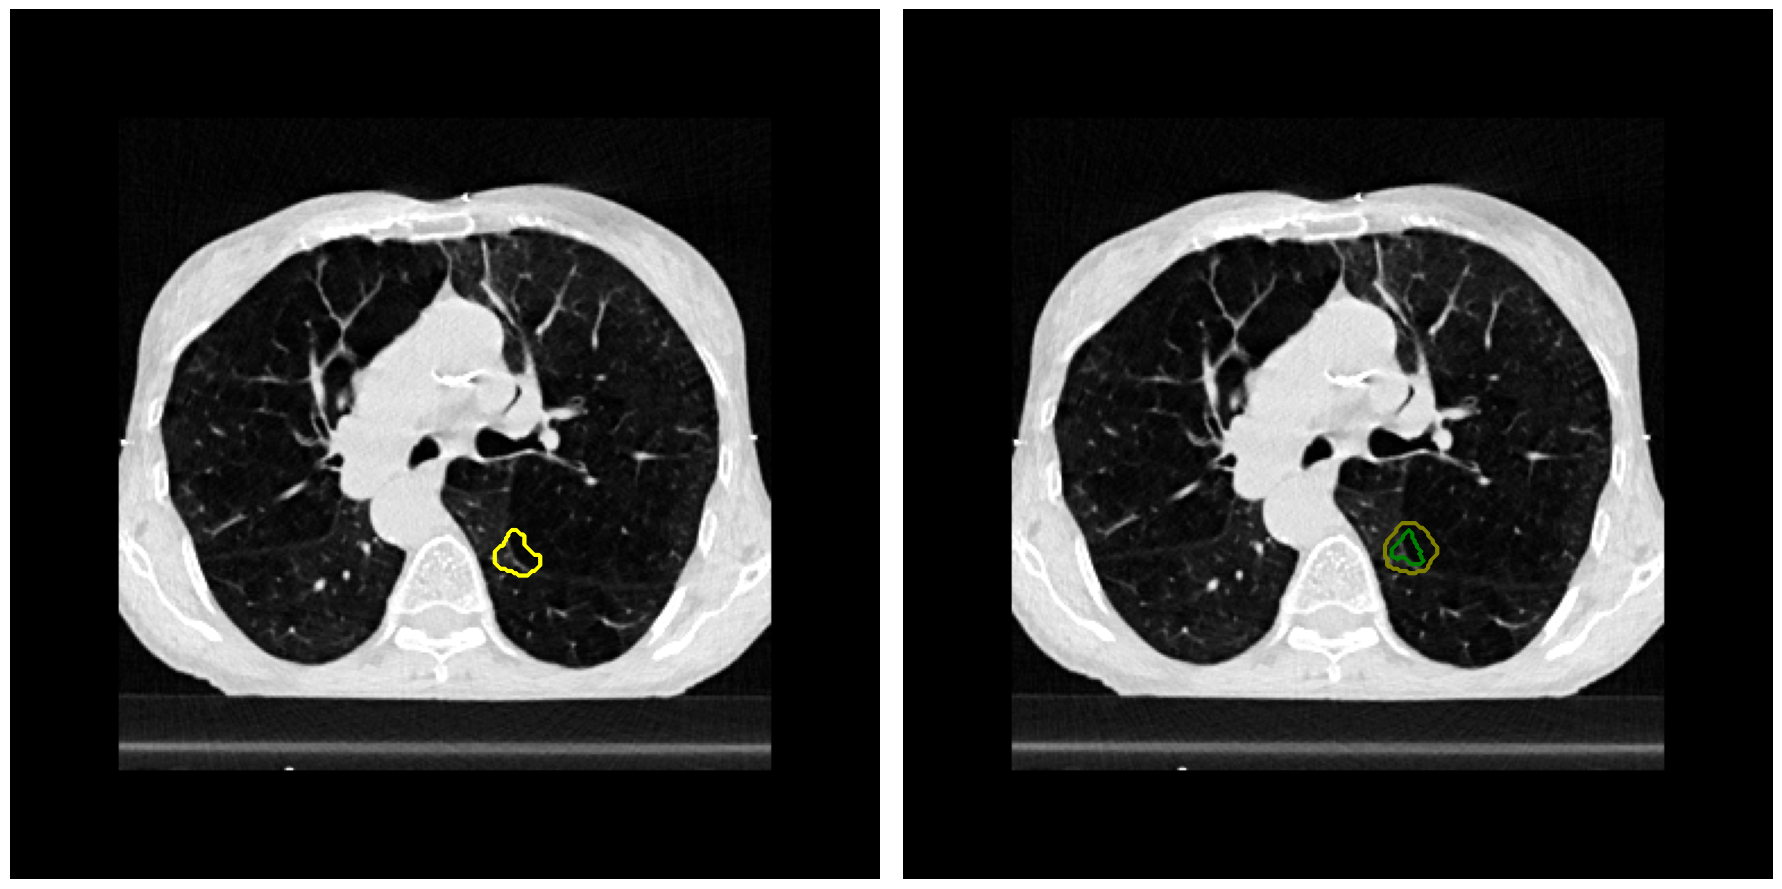

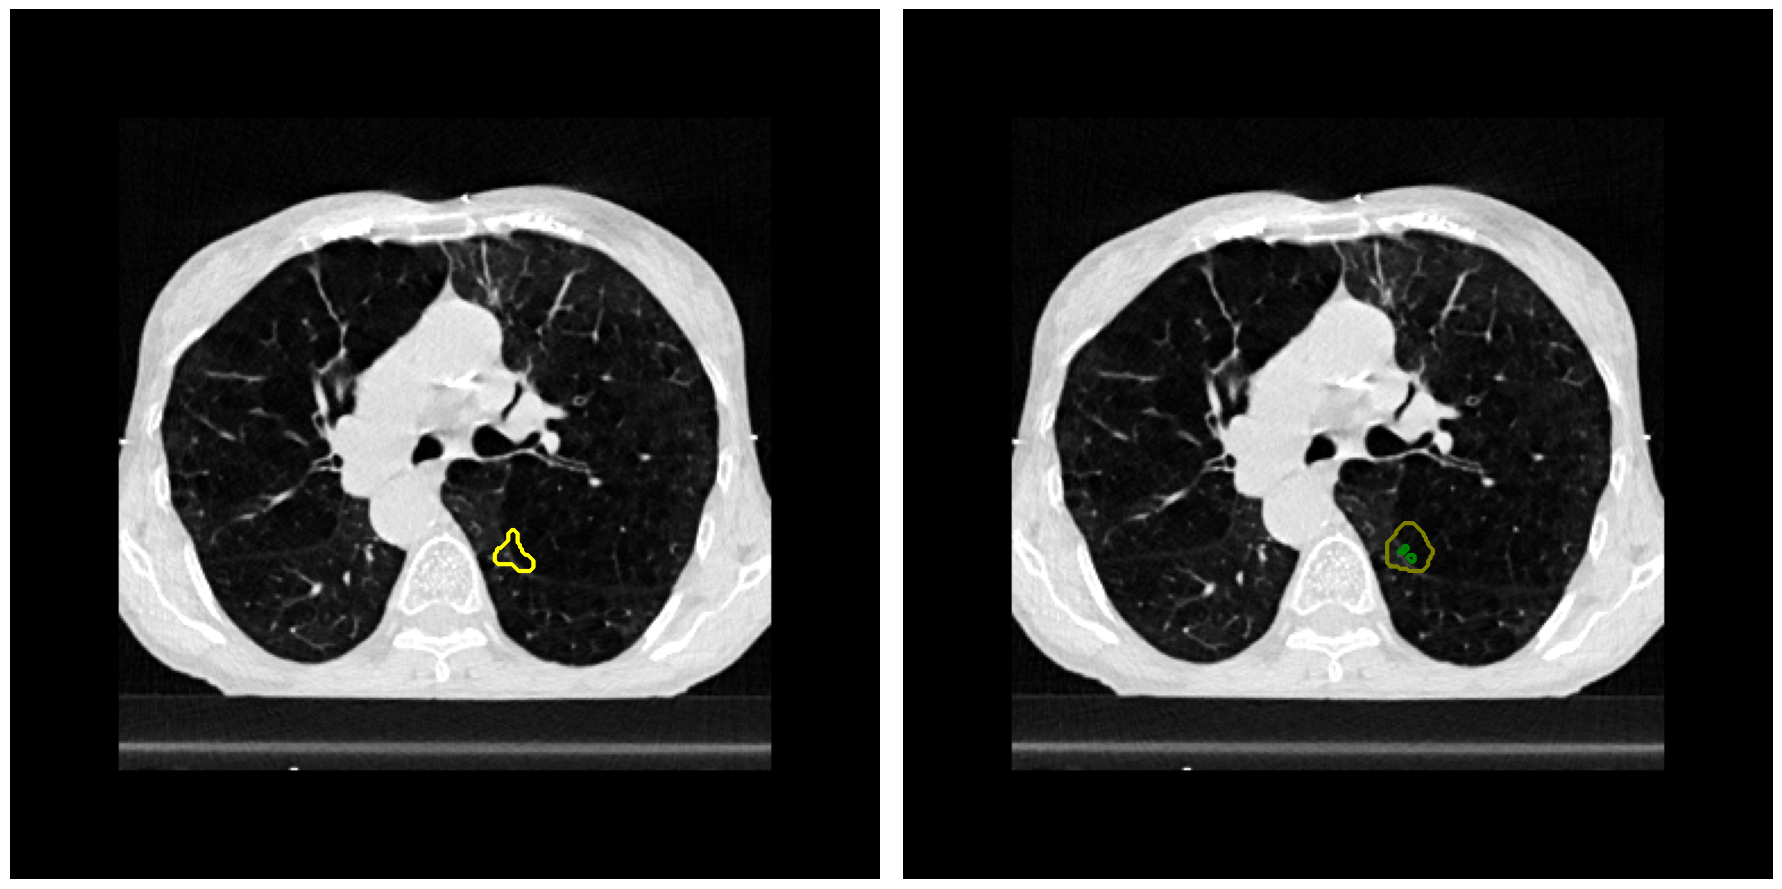

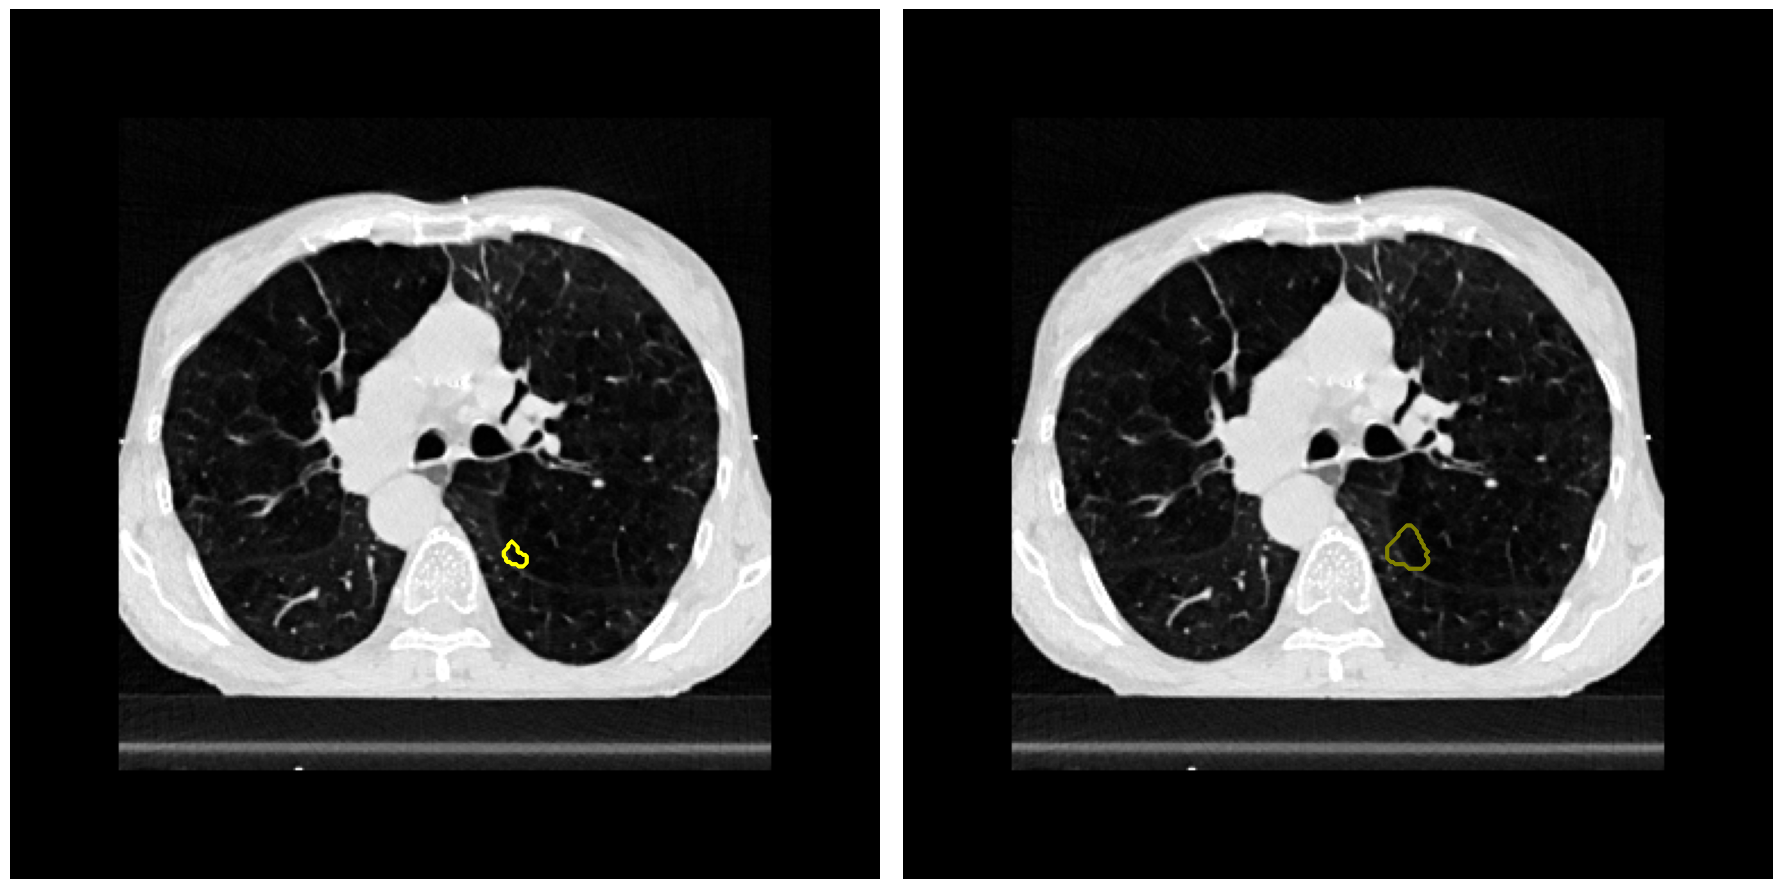

In [20]:
_ = customPlotITV(image,lung,itv_label,ITV_10BP,ITV_2BP,ITV_Opti,ITV_10BP_dil,ITV_2BP_dil,ITV_Opti_dil)

In [18]:
def customPlotITV(image,lung,itv_label,ITV_10BP,ITV_2BP,ITV_Opti,ITV_10BP_dil,ITV_2BP_dil,ITV_Opti_dil):
    figsize = (18, 9)
    ITV_10BP_bool=False
    ITV_10BP_dil_bool=False
    
    ITV_2BP_bool=False
    ITV_2BP_dil_bool=False
    
    ITV_Opti_bool=True
    ITV_Opti_dil_bool=True
    
    ITVlabel_bool = True

    for i in range(itv_label.shape[-1]):
        if torch.sum(itv_label[:,:,i])>0:
            fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
            ax = fig.add_subplot(121)
            ax.imshow(np.rot90(image[:,:, i]),cmap='gray'),plt.axis('off')
            ax.contour(np.rot90(itv_label[:,:,i]),colors='yellow')

            ax = fig.add_subplot(122)
            ax.imshow(np.rot90(image[:,:, i]),cmap='gray'),plt.axis('off')
            if ITV_10BP_bool:
                ax.contour(np.rot90(ITV_10BP[:,:,i]),colors='blue')
            if ITV_10BP_dil_bool:
                ax.contour(np.rot90(ITV_10BP_dil[:,:,i]),colors='cyan')
            if ITV_2BP_bool:    
                ax.contour(np.rot90(ITV_2BP[:,:,i]),colors='red')
            if ITV_2BP_dil_bool:
                ax.contour(np.rot90(ITV_2BP_dil[:,:,i]),colors='orange')
            if ITV_Opti_bool:
                ax.contour(np.rot90(ITV_Opti[:,:,i]),colors='green')
            if ITV_Opti_dil_bool:
                ax.contour(np.rot90(ITV_Opti_dil[:,:,i]),colors='olive')
            
            plt.tight_layout(),plt.show()
            
            
            
    return 0 